In [1]:
import nilearn
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting
import pylab

In [2]:
path = "X:/IntMem/analyses/Pierre/localizer/SPM"
subj = np.array(range(30))
#want to remove subjects [5,10,18,19,21]
excluded = np.array([4,9,17,18,20])
subj = np.delete(subj,excluded)
fs=["" for x in subj] #Path of each of the PPA contrast masks
for i in range(subj.size):
    n = subj[i]+1
    sub =  "/s" + str(n)
    fs[i] = path + sub + "/con1mask_PPA.nii"
PPA = [nib.load(i).get_data() for i in fs]
PPA_ac = [np.argwhere(i) for i in PPA] #storing all the activated voxels here
sizeAc = [PPA_ac[i].shape[0] for i in range(subj.size)]
print("Here are the number of active voxels in the contrast mask across subjects")
print(sizeAc)
print("The minimum number of voxels is %s for subject %s" % (np.min(sizeAc),np.where(sizeAc==np.min(sizeAc))[0][0]))
mSz = PPA[0].shape
refOne = np.ones(subj.size)
refZero = np.zeros(subj.size)
AllPPA = np.empty([mSz[0],mSz[1],mSz[2],subj.size])
for i in range(subj.size):
    AllPPA[:,:,:,i] = PPA[i]
print(AllPPA.shape)
print(PPA_ac[3])

Here are the number of active voxels in the contrast mask across subjects
[910L, 1193L, 1551L, 604L, 360L, 1232L, 1531L, 1198L, 923L, 287L, 1318L, 1157L, 716L, 1015L, 1068L, 295L, 1066L, 771L, 1234L, 781L, 1137L, 995L, 1117L, 403L, 1391L]
The minimum number of voxels is 287 for subject 9
(79L, 95L, 79L, 25L)
[[21 31 30]
 [21 32 29]
 [21 32 30]
 ..., 
 [56 38 25]
 [56 38 26]
 [56 38 27]]


In [3]:
import os
#This is an important parameter that we want to set for later analyses

path = "X:/IntMem/analyses/Pierre/localizer/"
os.chdir(path)
fname = "Block_Order.txt"
f = open(fname,"r")
cc = 0
order = [line.rstrip() for line in f] #rstrip removes the "\n" symbol
order2 = ["" for i in range(len(order)*2)]
for oo in order:
    order2[cc] = oo
    order2[cc+1] = oo
    cc = cc+2
F2,O2,S2 = np.zeros(len(order2)),np.zeros(len(order2)),np.zeros(len(order2))
for i in range(len(order2)):
    if(order2[i]=='F'):
        F2[i] = 1
    elif(order2[i]=='O'):
        O2[i] = 1
    else:
        S2[i] = 1
O_ind2 = np.argwhere(O2).flatten()
F_ind2 = np.argwhere(F2).flatten()
S_ind2 = np.argwhere(S2).flatten()
print(O_ind2)

[ 2  3  6  7 14 15 22 23 26 27 30 31 34 35 42 43 48 49 54 55]


In [7]:
#Important cell. Here we are dealing with the K-folds initialization for the MVPA cross-validation
K = 20
ResultsClf = np.zeros((subj.size,K))
NullRes = np.zeros((subj.size,K))
classification_accuracy = np.zeros(subj.size)
permuted_accuracy = np.zeros(subj.size)
p_values = np.zeros(subj.size) #p_values to report
chance_level = np.zeros(subj.size)
n_permutations = 1000
path = "X:/IntMem/data"

In [8]:
#Here, we are getting the x, y, z coordinates of all the voxels in the Nifti file
AllInds = np.zeros((mSz[0]*mSz[1]*mSz[2],3))
ii = 0
for v1 in range(mSz[0]):
    for v2 in range(mSz[1]):
        for v3 in range(mSz[2]):
            AllInds[ii] = [v1,v2,v3]
            ii = ii+1
print(AllInds)
print(mSz[0]*mSz[1]*mSz[2])

[[  0.   0.   0.]
 [  0.   0.   1.]
 [  0.   0.   2.]
 ..., 
 [ 78.  94.  76.]
 [ 78.  94.  77.]
 [ 78.  94.  78.]]
592895


In [9]:
#Apply PPA mask here
NewInds = np.zeros((subj.size,mSz[0]*mSz[1]*mSz[2]))
for su in range(subj.size):
    NewInds_curr = np.zeros((mSz[0],mSz[1],mSz[2]))
    curr_ac = PPA_ac[su]
    for i in range(curr_ac.shape[0]):
        curIdx = curr_ac[i]
        v1, v2, v3 = curIdx[0], curIdx[1], curIdx[2]
        NewInds_curr[v1,v2,v3] = 1
    NewInds_curr = NewInds_curr.flatten()
    NewInds[su] = np.array([int(x) for x in NewInds_curr])
print(NewInds_curr)
print(NewInds_curr.shape[0])
print(np.sum(NewInds_curr))
print(NewInds.shape)

[ 0.  0.  0. ...,  0.  0.  0.]
592895
1391.0
(25L, 592895L)


In [16]:
#Looping through all subjects
from os import listdir
from os.path import isfile, join
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
import sklearn

path = "X:/IntMem/data"
NbVoxels = 250
select250best = SelectKBest(score_func=f_classif, k=NbVoxels)
Torun = subj
for su in range(Torun.size): #Torun.size
    #Load the data from the localizer
    n = Torun[su]+1
    print("Currently dealing with subject %s" % n)
    sub =  "/s" + str(n)
    path_sub1 = path + sub + "/func/localizer/run1/"
    path_sub2 = path + sub + "/func/localizer/run2/"
    files1 = [f for f in listdir(path_sub1) if (isfile(join(path_sub1, f)) and f.startswith('swr'))]
    files2 = [f for f in listdir(path_sub2) if (isfile(join(path_sub2, f))and f.startswith('swr'))]
    fileR1 = path_sub1 + files1[0] 
    #Get the data here
    LocScansR1 = nib.load(fileR1).get_data()
    fileR2 = path_sub2 + files2[0]
    LocScansR2 = nib.load(fileR2).get_data()
    LocScans = np.concatenate((LocScansR1,LocScansR2),axis=3)
    NbScans = LocScans.shape[3]
    X = np.zeros((NbScans,NbVoxels))
    mod4ind = [i for i in range(NbScans) if ((np.mod(i,10)==3) or (np.mod(i,10)==6))]
    y_fit = np.transpose(S2)
    y_fit = np.delete(y_fit,O_ind2)
    Xsub = np.zeros((NbScans,LocScans.shape[0]*LocScans.shape[1]*LocScans.shape[2]))
    #Flatten patterns of neural activity
    for t in range(Xsub.shape[0]):
        Xsub[t,:] = LocScans[:,:,:,t].flatten()
    Xsub = Xsub[mod4ind,:]
    Xsub = np.delete(Xsub,O_ind2,0)
    nonzeros = np.sum(Xsub, axis=0) !=0
    nz = np.argwhere(nonzeros).flatten()
    X_nz = Xsub[:,nz]
    #Get demeaned data normalized based on the standard deviation for all non-zero voxels
    Xsub = (X_nz - np.mean(X_nz, axis=0,keepdims=True))/np.std(X_nz, axis=0, keepdims=True)
    NewInds_curr = NewInds[su]
    maskIndx = NewInds_curr[nz]
    Idx = np.argwhere(maskIndx).flatten()
    X_nz = Xsub[:,Idx]
    Inds_nz = AllInds[Idx]
    #Now, we want to select the 250 most informative voxels
    select250best.fit(X_nz,y_fit)
    Xdata = select250best.transform(X_nz)
    yChar = ["" for x in range(y_fit.shape[0])]
    for i in range(y_fit.shape[0]):
        if(y_fit[i]==1):
            yChar[i] = 'S'
        else:
            yChar[i] = 'F'
    #Making sure that we are NOT taking two consecutive scans in the test sets
    #Next, initialize k folds
    k_fold = KFold(n_splits=K,shuffle=True)
    while 1:
        AllGood = True
        for train_indices, test_indices in k_fold.split(Xdata):
            if(test_indices[1]==(test_indices[0]+1)):
                AllGood=False
                break
        if(AllGood==True):
            break
        else:
            k_fold = KFold(n_splits=K,shuffle=True)
    clf = LogisticRegression()
    #Logistic regression classifier
    ResultsClf[su,:] = cross_val_score(clf,Xdata,y_fit,cv=k_fold)
    classification_accuracy[su] = np.mean(ResultsClf[su,:])
    folds_accuracies = np.zeros(n_permutations)
    #Here we are performing the permutation tests 
    for i in range(n_permutations):
        #First make sure that the K-folds never have two scans from the same localizer series
        k_fold = KFold(n_splits=K,shuffle=True)
        while 1:
            AllGood = True
            for train_indices, test_indices in k_fold.split(Xdata):
                if(test_indices[1]==(test_indices[0]+1)):
                    AllGood=False
                    break
            if(AllGood==True):
                break
            else:
                k_fold = KFold(n_splits=K,shuffle=True)
        np.random.shuffle(y_fit) #shuffling the data
        folds_accuracies[i] = np.mean(cross_val_score(clf,Xdata,y_fit,cv=k_fold))
    permuted_accuracy[su] = np.mean(folds_accuracies)
    observed_acc = classification_accuracy[su]
    N=n_permutations
    #Finally, we compute the p-values after permutation tests. Note that they were all very low (p<0.01), so low that they show up as 0
    p_values[su] = np.sum((folds_accuracies>observed_acc)*1)/N

print("printing classification accuracy")
print(classification_accuracy)
print("printing permuted accuracy")
print(permuted_accuracy)
print("Mean Permutation accuracy")
print(np.mean(permuted_accuracy))
print("non-parametric p-values")
print(p_values)
print("mean p-value")
print(np.mean(p_values))

Currently dealing with subject 1
Currently dealing with subject 2
Currently dealing with subject 3
Currently dealing with subject 4
Currently dealing with subject 6
Currently dealing with subject 7
Currently dealing with subject 8
Currently dealing with subject 9
Currently dealing with subject 11
Currently dealing with subject 12
Currently dealing with subject 13
Currently dealing with subject 14
Currently dealing with subject 15
Currently dealing with subject 16
Currently dealing with subject 17
Currently dealing with subject 20
Currently dealing with subject 22
Currently dealing with subject 23
Currently dealing with subject 24
Currently dealing with subject 25
Currently dealing with subject 26
Currently dealing with subject 27
Currently dealing with subject 28
Currently dealing with subject 29
Currently dealing with subject 30
printing classification accuracy
[ 0.975  1.     1.     0.9    0.925  0.85   1.     0.85   0.875  0.85   0.95
  1.     0.9    0.95   0.925  0.825  0.975  0.92

In [17]:
print(np.amax(p_values))

0.0


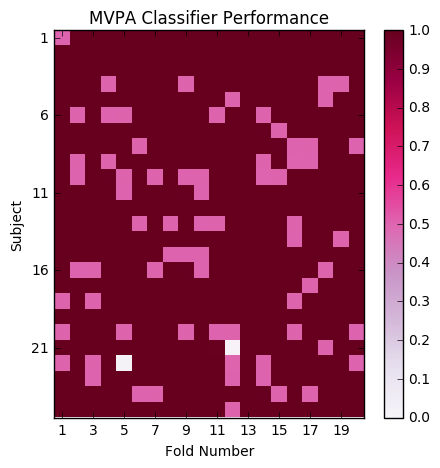

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
my_xticks = [1,3,5,7,9,11,13,15,17,19]
my_yticks = [1,6,11,16,21]
plt.imshow(ResultsClf, cmap = 'PuRd', interpolation='none', vmin=0.0, vmax=1.0)
plt.ylabel('Subject')
plt.xlabel('Fold Number')
plt.xticks([0,2,4,6,8,10,12,14,16,18], my_xticks)
plt.yticks([0,5,10,15,20],my_yticks)
plt.title('MVPA Classifier Performance')
plt.colorbar()
plt.show()

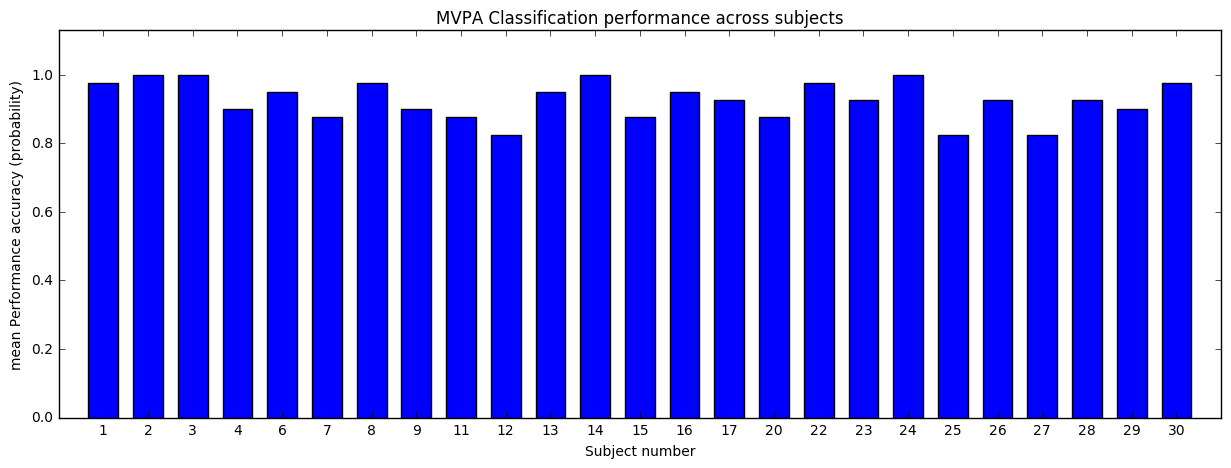

In [11]:
#Printing the classification results for all subjects as a bar graph
plt.figure(figsize=(15,5))
y = classification_accuracy
N = subj.size + 1
x = np.arange(1,N)
ss = [s+1 for s in subj]
width = 1/1.5
plt.bar(x, y, width, color="blue", align='center')
plt.xticks(x, ss)
plt.xlim([0,26])
plt.ylim([0,1.13])
plt.title('MVPA Classification performance across subjects')
plt.ylabel('mean Performance accuracy (probability)')
plt.xlabel('Subject number')
pylab.show()

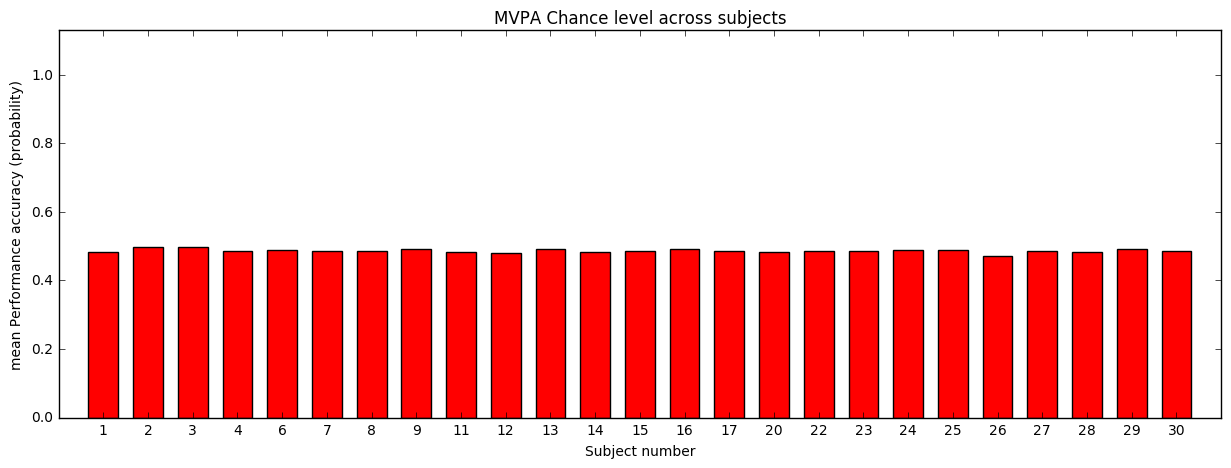

In [14]:
#Printing the chance level results for all subjects as a bar graph
plt.figure(figsize=(15,5))
y = permuted_accuracy
N = subj.size + 1
x = np.arange(1,N)
ss = [s+1 for s in subj]
width = 1/1.5
plt.bar(x, y, width, color="red", align='center')
plt.xticks(x, ss)
plt.xticks(np.arange(1,N))
plt.xlim([0,26])
plt.ylim([0,1.13])
plt.title('MVPA Chance level across subjects')
plt.ylabel('mean Performance accuracy (probability)')
plt.xlabel('Subject number')
pylab.show()

In [13]:
print(np.mean(classification_accuracy))
print(np.std(classification_accuracy))

0.925


In [15]:
print(np.mean(permuted_accuracy))
print(np.std(permuted_accuracy))

0.486731
